In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, date

In [2]:
from train_val_test_data import RegressionDataset
from regression_model import MultipleRegression

In [3]:
#Reading data
data = pd.read_csv('data_daily.csv')

In [4]:
#Modifying the dataframe
data['# Date'] = pd.to_datetime(data['# Date'])
data['# Month'] = data['# Date'].dt.month
data['# DayofWeek'] = data['# Date'].dt.dayofweek
data['index'] = data.index
data.set_index('index')


,# Date,Receipt_Count,# Month,# DayofWeek
index,,,,
0,2021-01-01,7564766,1,4
1,2021-01-02,7455524,1,5
2,2021-01-03,7095414,1,6
3,2021-01-04,7666163,1,0
4,2021-01-05,7771289,1,1
...,...,...,...,...
360,2021-12-27,10350408,12,0
361,2021-12-28,10219445,12,1
362,2021-12-29,10313337,12,2


In [5]:
X = np.array(data[['index', '# Month', '# DayofWeek']])
y = np.array(data['Receipt_Count']).reshape(-1,1)

In [6]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

scaler1 = MinMaxScaler()
y_train = scaler1.fit_transform(y_train)
y_val = scaler1.transform(y_val)
y_test = scaler1.transform(y_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [8]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

In [9]:
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [10]:
EPOCHS = 150
BATCH_SIZE = 1
LEARNING_RATE = 0.0001
NUM_FEATURES = 3

In [11]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=3, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


In [14]:
loss_stats = {
    'train': [],
    "val": []
}

In [15]:
for i in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
        
    # if i%25==0:
    print(f'Epoch {i}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

  0%|          | 0/150 [00:00<?, ?it/s]c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 1/150 [00:02<05:52,  2.36s/it]

Epoch 1: | Train Loss: 0.55755 | Val Loss: 0.52698


  1%|▏         | 2/150 [00:03<03:20,  1.35s/it]

Epoch 2: | Train Loss: 0.42239 | Val Loss: 0.39220


  2%|▏         | 3/150 [00:03<02:32,  1.03s/it]

Epoch 3: | Train Loss: 0.30835 | Val Loss: 0.27790


  3%|▎         | 4/150 [00:04<02:09,  1.12it/s]

Epoch 4: | Train Loss: 0.21357 | Val Loss: 0.18426


  3%|▎         | 5/150 [00:05<01:58,  1.23it/s]

Epoch 5: | Train Loss: 0.13786 | Val Loss: 0.11264


  4%|▍         | 6/150 [00:05<01:51,  1.30it/s]

Epoch 6: | Train Loss: 0.08254 | Val Loss: 0.06420


  5%|▍         | 7/150 [00:06<01:45,  1.36it/s]

Epoch 7: | Train Loss: 0.04761 | Val Loss: 0.03685


  5%|▌         | 8/150 [00:07<01:40,  1.42it/s]

Epoch 8: | Train Loss: 0.02895 | Val Loss: 0.02398


  6%|▌         | 9/150 [00:07<01:36,  1.46it/s]

Epoch 9: | Train Loss: 0.02036 | Val Loss: 0.01841


  7%|▋         | 10/150 [00:08<01:35,  1.47it/s]

Epoch 10: | Train Loss: 0.01652 | Val Loss: 0.01617


  7%|▋         | 11/150 [00:08<01:33,  1.48it/s]

Epoch 11: | Train Loss: 0.01456 | Val Loss: 0.01481


  8%|▊         | 12/150 [00:09<01:31,  1.50it/s]

Epoch 12: | Train Loss: 0.01326 | Val Loss: 0.01367


  9%|▊         | 13/150 [00:10<01:29,  1.53it/s]

Epoch 13: | Train Loss: 0.01209 | Val Loss: 0.01260


  9%|▉         | 14/150 [00:10<01:28,  1.53it/s]

Epoch 14: | Train Loss: 0.01100 | Val Loss: 0.01138


 10%|█         | 15/150 [00:11<01:27,  1.55it/s]

Epoch 15: | Train Loss: 0.00998 | Val Loss: 0.01024


 11%|█         | 16/150 [00:12<01:26,  1.55it/s]

Epoch 16: | Train Loss: 0.00907 | Val Loss: 0.00926


 11%|█▏        | 17/150 [00:12<01:25,  1.55it/s]

Epoch 17: | Train Loss: 0.00831 | Val Loss: 0.00844


 12%|█▏        | 18/150 [00:13<01:26,  1.53it/s]

Epoch 18: | Train Loss: 0.00767 | Val Loss: 0.00771


 13%|█▎        | 19/150 [00:14<01:24,  1.55it/s]

Epoch 19: | Train Loss: 0.00713 | Val Loss: 0.00706


 13%|█▎        | 20/150 [00:14<01:22,  1.57it/s]

Epoch 20: | Train Loss: 0.00673 | Val Loss: 0.00653


 14%|█▍        | 21/150 [00:15<01:21,  1.57it/s]

Epoch 21: | Train Loss: 0.00641 | Val Loss: 0.00614


 15%|█▍        | 22/150 [00:16<01:21,  1.57it/s]

Epoch 22: | Train Loss: 0.00618 | Val Loss: 0.00584


 15%|█▌        | 23/150 [00:16<01:21,  1.56it/s]

Epoch 23: | Train Loss: 0.00602 | Val Loss: 0.00557


 16%|█▌        | 24/150 [00:17<01:22,  1.53it/s]

Epoch 24: | Train Loss: 0.00590 | Val Loss: 0.00536


 17%|█▋        | 26/150 [00:18<01:19,  1.56it/s]

Epoch 26: | Train Loss: 0.00572 | Val Loss: 0.00508


 18%|█▊        | 27/150 [00:19<01:19,  1.54it/s]

Epoch 27: | Train Loss: 0.00567 | Val Loss: 0.00498


 19%|█▊        | 28/150 [00:19<01:19,  1.54it/s]

Epoch 28: | Train Loss: 0.00561 | Val Loss: 0.00490


 19%|█▉        | 29/150 [00:20<01:18,  1.54it/s]

Epoch 29: | Train Loss: 0.00558 | Val Loss: 0.00485


 20%|██        | 30/150 [00:21<01:17,  1.54it/s]

Epoch 30: | Train Loss: 0.00555 | Val Loss: 0.00480


 21%|██        | 31/150 [00:21<01:16,  1.55it/s]

Epoch 31: | Train Loss: 0.00553 | Val Loss: 0.00476


 21%|██▏       | 32/150 [00:22<01:16,  1.55it/s]

Epoch 32: | Train Loss: 0.00551 | Val Loss: 0.00473


 22%|██▏       | 33/150 [00:23<01:14,  1.57it/s]

Epoch 33: | Train Loss: 0.00545 | Val Loss: 0.00476


 23%|██▎       | 34/150 [00:23<01:15,  1.54it/s]

Epoch 34: | Train Loss: 0.00548 | Val Loss: 0.00470


 23%|██▎       | 35/150 [00:24<01:14,  1.54it/s]

Epoch 35: | Train Loss: 0.00547 | Val Loss: 0.00470


 24%|██▍       | 36/150 [00:25<01:13,  1.54it/s]

Epoch 36: | Train Loss: 0.00546 | Val Loss: 0.00469


 25%|██▍       | 37/150 [00:25<01:12,  1.55it/s]

Epoch 37: | Train Loss: 0.00543 | Val Loss: 0.00469


 25%|██▌       | 38/150 [00:26<01:12,  1.54it/s]

Epoch 38: | Train Loss: 0.00543 | Val Loss: 0.00469


 26%|██▌       | 39/150 [00:27<01:13,  1.50it/s]

Epoch 39: | Train Loss: 0.00540 | Val Loss: 0.00473


 27%|██▋       | 40/150 [00:27<01:13,  1.49it/s]

Epoch 40: | Train Loss: 0.00539 | Val Loss: 0.00471


 27%|██▋       | 41/150 [00:28<01:11,  1.52it/s]

Epoch 41: | Train Loss: 0.00539 | Val Loss: 0.00471


 28%|██▊       | 42/150 [00:28<01:09,  1.56it/s]

Epoch 42: | Train Loss: 0.00539 | Val Loss: 0.00471


 29%|██▊       | 43/150 [00:29<01:07,  1.60it/s]

Epoch 43: | Train Loss: 0.00537 | Val Loss: 0.00471


 29%|██▉       | 44/150 [00:30<01:06,  1.59it/s]

Epoch 44: | Train Loss: 0.00535 | Val Loss: 0.00474


 30%|███       | 45/150 [00:30<01:04,  1.63it/s]

Epoch 45: | Train Loss: 0.00535 | Val Loss: 0.00474


 31%|███       | 46/150 [00:31<01:05,  1.59it/s]

Epoch 46: | Train Loss: 0.00535 | Val Loss: 0.00472


 31%|███▏      | 47/150 [00:32<01:06,  1.55it/s]

Epoch 47: | Train Loss: 0.00534 | Val Loss: 0.00472


 32%|███▏      | 48/150 [00:32<01:05,  1.57it/s]

Epoch 48: | Train Loss: 0.00532 | Val Loss: 0.00475


 33%|███▎      | 49/150 [00:33<01:06,  1.52it/s]

Epoch 49: | Train Loss: 0.00535 | Val Loss: 0.00475


 34%|███▍      | 51/150 [00:34<01:04,  1.53it/s]

Epoch 51: | Train Loss: 0.00533 | Val Loss: 0.00475


 35%|███▍      | 52/150 [00:35<01:02,  1.56it/s]

Epoch 52: | Train Loss: 0.00530 | Val Loss: 0.00475


 35%|███▌      | 53/150 [00:36<01:01,  1.58it/s]

Epoch 53: | Train Loss: 0.00529 | Val Loss: 0.00475


 36%|███▌      | 54/150 [00:36<01:00,  1.60it/s]

Epoch 54: | Train Loss: 0.00528 | Val Loss: 0.00475


 37%|███▋      | 55/150 [00:37<00:59,  1.59it/s]

Epoch 55: | Train Loss: 0.00529 | Val Loss: 0.00476


 37%|███▋      | 56/150 [00:38<01:02,  1.51it/s]

Epoch 56: | Train Loss: 0.00528 | Val Loss: 0.00475


 38%|███▊      | 57/150 [00:38<01:02,  1.49it/s]

Epoch 57: | Train Loss: 0.00527 | Val Loss: 0.00476


 39%|███▊      | 58/150 [00:39<01:02,  1.47it/s]

Epoch 58: | Train Loss: 0.00527 | Val Loss: 0.00477


 39%|███▉      | 59/150 [00:40<01:00,  1.51it/s]

Epoch 59: | Train Loss: 0.00527 | Val Loss: 0.00478


 40%|████      | 60/150 [00:40<00:59,  1.52it/s]

Epoch 60: | Train Loss: 0.00526 | Val Loss: 0.00478


 41%|████      | 61/150 [00:41<00:58,  1.52it/s]

Epoch 61: | Train Loss: 0.00523 | Val Loss: 0.00481


 41%|████▏     | 62/150 [00:41<00:57,  1.54it/s]

Epoch 62: | Train Loss: 0.00524 | Val Loss: 0.00479


 42%|████▏     | 63/150 [00:42<00:58,  1.49it/s]

Epoch 63: | Train Loss: 0.00526 | Val Loss: 0.00479


 43%|████▎     | 64/150 [00:43<00:58,  1.47it/s]

Epoch 64: | Train Loss: 0.00521 | Val Loss: 0.00484


 43%|████▎     | 65/150 [00:44<00:56,  1.50it/s]

Epoch 65: | Train Loss: 0.00525 | Val Loss: 0.00480


 44%|████▍     | 66/150 [00:44<00:54,  1.54it/s]

Epoch 66: | Train Loss: 0.00525 | Val Loss: 0.00478


 45%|████▍     | 67/150 [00:45<00:53,  1.57it/s]

Epoch 67: | Train Loss: 0.00524 | Val Loss: 0.00479


 45%|████▌     | 68/150 [00:45<00:53,  1.55it/s]

Epoch 68: | Train Loss: 0.00524 | Val Loss: 0.00478


 46%|████▌     | 69/150 [00:46<00:52,  1.55it/s]

Epoch 69: | Train Loss: 0.00523 | Val Loss: 0.00477


 47%|████▋     | 70/150 [00:47<00:53,  1.49it/s]

Epoch 70: | Train Loss: 0.00522 | Val Loss: 0.00478


 47%|████▋     | 71/150 [00:47<00:51,  1.53it/s]

Epoch 71: | Train Loss: 0.00522 | Val Loss: 0.00478


 48%|████▊     | 72/150 [00:48<00:51,  1.51it/s]

Epoch 72: | Train Loss: 0.00522 | Val Loss: 0.00478


 49%|████▊     | 73/150 [00:49<00:51,  1.50it/s]

Epoch 73: | Train Loss: 0.00522 | Val Loss: 0.00478


 49%|████▉     | 74/150 [00:49<00:49,  1.53it/s]

Epoch 74: | Train Loss: 0.00520 | Val Loss: 0.00478


 51%|█████     | 76/150 [00:51<00:57,  1.28it/s]

Epoch 76: | Train Loss: 0.00524 | Val Loss: 0.00478


 51%|█████▏    | 77/150 [00:52<00:52,  1.38it/s]

Epoch 77: | Train Loss: 0.00521 | Val Loss: 0.00479


 52%|█████▏    | 78/150 [00:52<00:51,  1.40it/s]

Epoch 78: | Train Loss: 0.00520 | Val Loss: 0.00480


 53%|█████▎    | 79/150 [00:53<00:50,  1.40it/s]

Epoch 79: | Train Loss: 0.00521 | Val Loss: 0.00479


 53%|█████▎    | 80/150 [00:54<00:50,  1.39it/s]

Epoch 80: | Train Loss: 0.00518 | Val Loss: 0.00479


 54%|█████▍    | 81/150 [00:55<00:48,  1.43it/s]

Epoch 81: | Train Loss: 0.00521 | Val Loss: 0.00483


 55%|█████▍    | 82/150 [00:55<00:46,  1.46it/s]

Epoch 82: | Train Loss: 0.00518 | Val Loss: 0.00486


 55%|█████▌    | 83/150 [00:56<00:48,  1.37it/s]

Epoch 83: | Train Loss: 0.00520 | Val Loss: 0.00484


 56%|█████▌    | 84/150 [00:57<00:49,  1.35it/s]

Epoch 84: | Train Loss: 0.00516 | Val Loss: 0.00487


 57%|█████▋    | 85/150 [00:58<00:47,  1.36it/s]

Epoch 85: | Train Loss: 0.00517 | Val Loss: 0.00485


 57%|█████▋    | 86/150 [00:58<00:48,  1.32it/s]

Epoch 86: | Train Loss: 0.00517 | Val Loss: 0.00485


 58%|█████▊    | 87/150 [00:59<00:47,  1.33it/s]

Epoch 87: | Train Loss: 0.00517 | Val Loss: 0.00485


 59%|█████▊    | 88/150 [01:00<00:48,  1.28it/s]

Epoch 88: | Train Loss: 0.00518 | Val Loss: 0.00485


 59%|█████▉    | 89/150 [01:01<00:47,  1.27it/s]

Epoch 89: | Train Loss: 0.00515 | Val Loss: 0.00484


 60%|██████    | 90/150 [01:01<00:46,  1.29it/s]

Epoch 90: | Train Loss: 0.00515 | Val Loss: 0.00486


 61%|██████    | 91/150 [01:02<00:45,  1.30it/s]

Epoch 91: | Train Loss: 0.00518 | Val Loss: 0.00485


 61%|██████▏   | 92/150 [01:03<00:42,  1.37it/s]

Epoch 92: | Train Loss: 0.00514 | Val Loss: 0.00487


 62%|██████▏   | 93/150 [01:04<00:40,  1.41it/s]

Epoch 93: | Train Loss: 0.00517 | Val Loss: 0.00489


 63%|██████▎   | 94/150 [01:04<00:38,  1.45it/s]

Epoch 94: | Train Loss: 0.00514 | Val Loss: 0.00490


 63%|██████▎   | 95/150 [01:05<00:37,  1.46it/s]

Epoch 95: | Train Loss: 0.00514 | Val Loss: 0.00490


 64%|██████▍   | 96/150 [01:05<00:36,  1.48it/s]

Epoch 96: | Train Loss: 0.00515 | Val Loss: 0.00492


 65%|██████▍   | 97/150 [01:06<00:35,  1.50it/s]

Epoch 97: | Train Loss: 0.00514 | Val Loss: 0.00491


 65%|██████▌   | 98/150 [01:07<00:34,  1.51it/s]

Epoch 98: | Train Loss: 0.00515 | Val Loss: 0.00492


 66%|██████▌   | 99/150 [01:07<00:33,  1.53it/s]

Epoch 99: | Train Loss: 0.00514 | Val Loss: 0.00492


 67%|██████▋   | 101/150 [01:09<00:31,  1.55it/s]

Epoch 101: | Train Loss: 0.00512 | Val Loss: 0.00492


 68%|██████▊   | 102/150 [01:09<00:30,  1.57it/s]

Epoch 102: | Train Loss: 0.00513 | Val Loss: 0.00492


 69%|██████▊   | 103/150 [01:10<00:29,  1.57it/s]

Epoch 103: | Train Loss: 0.00515 | Val Loss: 0.00492


 69%|██████▉   | 104/150 [01:11<00:29,  1.55it/s]

Epoch 104: | Train Loss: 0.00514 | Val Loss: 0.00491


 70%|███████   | 105/150 [01:11<00:28,  1.57it/s]

Epoch 105: | Train Loss: 0.00514 | Val Loss: 0.00492


 71%|███████   | 106/150 [01:12<00:28,  1.52it/s]

Epoch 106: | Train Loss: 0.00515 | Val Loss: 0.00491


 71%|███████▏  | 107/150 [01:13<00:28,  1.51it/s]

Epoch 107: | Train Loss: 0.00513 | Val Loss: 0.00491


 72%|███████▏  | 108/150 [01:13<00:27,  1.51it/s]

Epoch 108: | Train Loss: 0.00513 | Val Loss: 0.00492


 73%|███████▎  | 109/150 [01:14<00:27,  1.47it/s]

Epoch 109: | Train Loss: 0.00512 | Val Loss: 0.00491


 73%|███████▎  | 110/150 [01:15<00:27,  1.43it/s]

Epoch 110: | Train Loss: 0.00512 | Val Loss: 0.00493


 74%|███████▍  | 111/150 [01:15<00:26,  1.45it/s]

Epoch 111: | Train Loss: 0.00513 | Val Loss: 0.00490


 75%|███████▍  | 112/150 [01:16<00:26,  1.43it/s]

Epoch 112: | Train Loss: 0.00513 | Val Loss: 0.00492


 75%|███████▌  | 113/150 [01:17<00:26,  1.41it/s]

Epoch 113: | Train Loss: 0.00511 | Val Loss: 0.00492


 76%|███████▌  | 114/150 [01:18<00:25,  1.41it/s]

Epoch 114: | Train Loss: 0.00513 | Val Loss: 0.00493


 77%|███████▋  | 115/150 [01:18<00:25,  1.38it/s]

Epoch 115: | Train Loss: 0.00513 | Val Loss: 0.00492


 77%|███████▋  | 116/150 [01:19<00:23,  1.43it/s]

Epoch 116: | Train Loss: 0.00512 | Val Loss: 0.00494


 78%|███████▊  | 117/150 [01:20<00:22,  1.47it/s]

Epoch 117: | Train Loss: 0.00514 | Val Loss: 0.00493


 79%|███████▊  | 118/150 [01:20<00:22,  1.40it/s]

Epoch 118: | Train Loss: 0.00511 | Val Loss: 0.00491


 79%|███████▉  | 119/150 [01:21<00:23,  1.34it/s]

Epoch 119: | Train Loss: 0.00511 | Val Loss: 0.00496


 80%|████████  | 120/150 [01:22<00:24,  1.23it/s]

Epoch 120: | Train Loss: 0.00514 | Val Loss: 0.00492


 81%|████████  | 121/150 [01:23<00:23,  1.25it/s]

Epoch 121: | Train Loss: 0.00507 | Val Loss: 0.00495


 81%|████████▏ | 122/150 [01:24<00:23,  1.21it/s]

Epoch 122: | Train Loss: 0.00511 | Val Loss: 0.00491


 82%|████████▏ | 123/150 [01:25<00:23,  1.15it/s]

Epoch 123: | Train Loss: 0.00513 | Val Loss: 0.00491


 83%|████████▎ | 124/150 [01:26<00:22,  1.15it/s]

Epoch 124: | Train Loss: 0.00512 | Val Loss: 0.00491


 84%|████████▍ | 126/150 [01:27<00:19,  1.23it/s]

Epoch 126: | Train Loss: 0.00513 | Val Loss: 0.00491


 85%|████████▍ | 127/150 [01:28<00:17,  1.29it/s]

Epoch 127: | Train Loss: 0.00513 | Val Loss: 0.00492


 85%|████████▌ | 128/150 [01:29<00:16,  1.33it/s]

Epoch 128: | Train Loss: 0.00510 | Val Loss: 0.00492


 86%|████████▌ | 129/150 [01:29<00:15,  1.35it/s]

Epoch 129: | Train Loss: 0.00508 | Val Loss: 0.00494


 87%|████████▋ | 130/150 [01:30<00:15,  1.32it/s]

Epoch 130: | Train Loss: 0.00510 | Val Loss: 0.00494


 87%|████████▋ | 131/150 [01:31<00:14,  1.31it/s]

Epoch 131: | Train Loss: 0.00511 | Val Loss: 0.00492


 88%|████████▊ | 132/150 [01:32<00:13,  1.34it/s]

Epoch 132: | Train Loss: 0.00513 | Val Loss: 0.00492


 89%|████████▊ | 133/150 [01:32<00:12,  1.39it/s]

Epoch 133: | Train Loss: 0.00511 | Val Loss: 0.00490


 89%|████████▉ | 134/150 [01:33<00:11,  1.42it/s]

Epoch 134: | Train Loss: 0.00511 | Val Loss: 0.00493


 90%|█████████ | 135/150 [01:34<00:10,  1.45it/s]

Epoch 135: | Train Loss: 0.00513 | Val Loss: 0.00493


 91%|█████████ | 136/150 [01:34<00:09,  1.46it/s]

Epoch 136: | Train Loss: 0.00512 | Val Loss: 0.00491


 91%|█████████▏| 137/150 [01:35<00:08,  1.48it/s]

Epoch 137: | Train Loss: 0.00514 | Val Loss: 0.00492


 92%|█████████▏| 138/150 [01:36<00:07,  1.51it/s]

Epoch 138: | Train Loss: 0.00510 | Val Loss: 0.00494


 93%|█████████▎| 139/150 [01:36<00:07,  1.49it/s]

Epoch 139: | Train Loss: 0.00511 | Val Loss: 0.00493


 93%|█████████▎| 140/150 [01:37<00:06,  1.48it/s]

Epoch 140: | Train Loss: 0.00511 | Val Loss: 0.00492


 94%|█████████▍| 141/150 [01:38<00:06,  1.50it/s]

Epoch 141: | Train Loss: 0.00511 | Val Loss: 0.00492


 95%|█████████▍| 142/150 [01:38<00:05,  1.51it/s]

Epoch 142: | Train Loss: 0.00511 | Val Loss: 0.00492


 95%|█████████▌| 143/150 [01:39<00:04,  1.51it/s]

Epoch 143: | Train Loss: 0.00511 | Val Loss: 0.00491


 96%|█████████▌| 144/150 [01:40<00:03,  1.53it/s]

Epoch 144: | Train Loss: 0.00512 | Val Loss: 0.00490


 97%|█████████▋| 145/150 [01:40<00:03,  1.49it/s]

Epoch 145: | Train Loss: 0.00512 | Val Loss: 0.00494


 97%|█████████▋| 146/150 [01:41<00:02,  1.50it/s]

Epoch 146: | Train Loss: 0.00515 | Val Loss: 0.00492


 98%|█████████▊| 147/150 [01:42<00:02,  1.48it/s]

Epoch 147: | Train Loss: 0.00511 | Val Loss: 0.00493


 99%|█████████▊| 148/150 [01:42<00:01,  1.49it/s]

Epoch 148: | Train Loss: 0.00511 | Val Loss: 0.00493


 99%|█████████▉| 149/150 [01:43<00:00,  1.51it/s]

Epoch 149: | Train Loss: 0.00513 | Val Loss: 0.00492


100%|██████████| 150/150 [01:44<00:00,  1.44it/s]


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

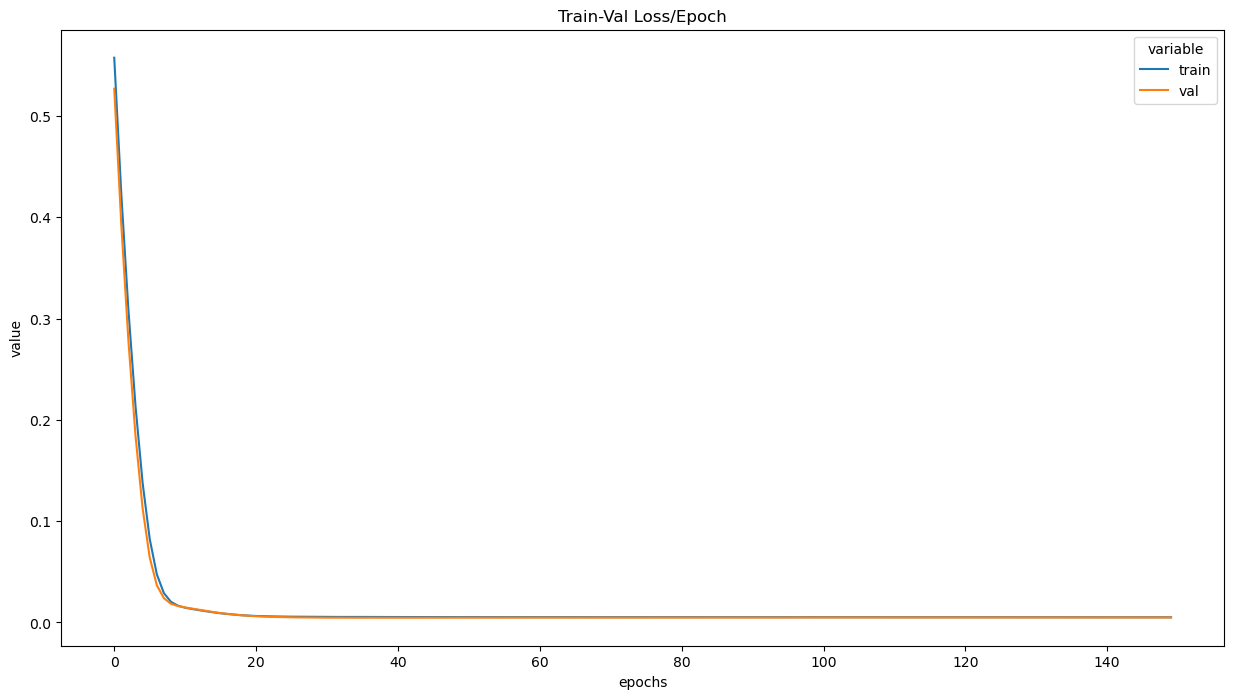

In [16]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [17]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [18]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.00625522336832056
R^2 : 0.9122778461947291


In [19]:
import pickle
pickle.dump(scaler, open('scalerx.pkl','wb'))
pickle.dump(scaler1, open('scalery.pkl','wb'))

In [20]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save